## 1.2 Clustering Experiment 
### Generate Data

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define the parameters for the Gaussian distributions
means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]
covariances = [
    np.array([[2, 0.5], [0.5, 1]]),
    np.array([[1, -0.5], [-0.5, 2]]),
    np.array([[1, 0], [0, 2]])
]

# Number of samples per cluster
n_samples = 100

# Define the range for sigma
sigma_values = [0.5, 1, 2, 4, 8]

# Generate the synthetic datasets for each sigma value
datasets = {}
for sigma in sigma_values:
    # Scale the covariances by the current sigma value
    scaled_covariances = [sigma * cov for cov in covariances]
    
    # Generate the synthetic dataset
    datasets[sigma] = np.concatenate([
        np.random.multivariate_normal(mean, cov, size=n_samples)
        for mean, cov in zip(means, scaled_covariances)
    ])

datasets_sigma_shapes = {sigma: data.shape for sigma, data in datasets.items()}
datasets_sigma_shapes


{0.5: (300, 2), 1: (300, 2), 2: (300, 2), 4: (300, 2), 8: (300, 2)}

### K-Means Implementation 
1. Pick K random cluster centers
2. Assign each point in dataset to the closest center
3. For each cluster, find the centriod of points in that cluster
4. Define the centriod as the new center and repeat steps 2-4 until convergence. 

In [41]:
# K-means algorithm implementation
def kmeans(X, k, max_iters=100):
    # Step 1: Initialize cluster centroids
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    for _ in range(max_iters):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        closest_centroids = np.argmin(distances, axis=0)

        # Step 3: Update each centroid to the mean of the points assigned to it
        new_centroids = np.array([X[closest_centroids == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence (if centroids do not change)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, closest_centroids

### EM Algorithm for GMM Implementation 
1. Pick K random cluster centers 
2. Generate a gaussian at each center with mean $\mu$ and covariance $\Sigma$.
3. Assign all points in dataset to the most likely gaussian 
4. Update the $\mu$ and $\Sigma$ parameters of the gaussians to better fit the cluster labeled data
5. Repeat steps 3-4 until convergence 

In [42]:
from scipy.stats import multivariate_normal
def gmm_em(X, k, max_iters=100):
    # Step 1: Initialize parameters
    n, d = X.shape
    means = X[np.random.choice(range(n), k, replace=False)]
    covariances = [np.eye(d) for _ in range(k)]
    pis = np.ones(k) / k
    responsibilities = np.zeros((n, k))
    
    for _ in range(max_iters):
        # E-step: Calculate responsibilities
        for i in range(k):
            rv = multivariate_normal(means[i], covariances[i])
            responsibilities[:, i] = pis[i] * rv.pdf(X)
        responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
        
        # M-step: Update parameters
        Nk = responsibilities.sum(axis=0)
        means = np.array([np.sum(responsibilities[:, j][:, np.newaxis] * X, axis=0) / Nk[j] for j in range(k)])
        covariances = [np.dot((responsibilities[:, j][:, np.newaxis] * (X - means[j])).T, X - means[j]) / Nk[j] for j in range(k)]
        pis = Nk / n
        
        # Check for convergence: Typically we check if the log-likelihood has converged,
        # but for simplicity here, one could check if the parameters have stopped changing
        # or set a fixed number of iterations.

    return means, covariances, pis, responsibilities


### Evaluation 

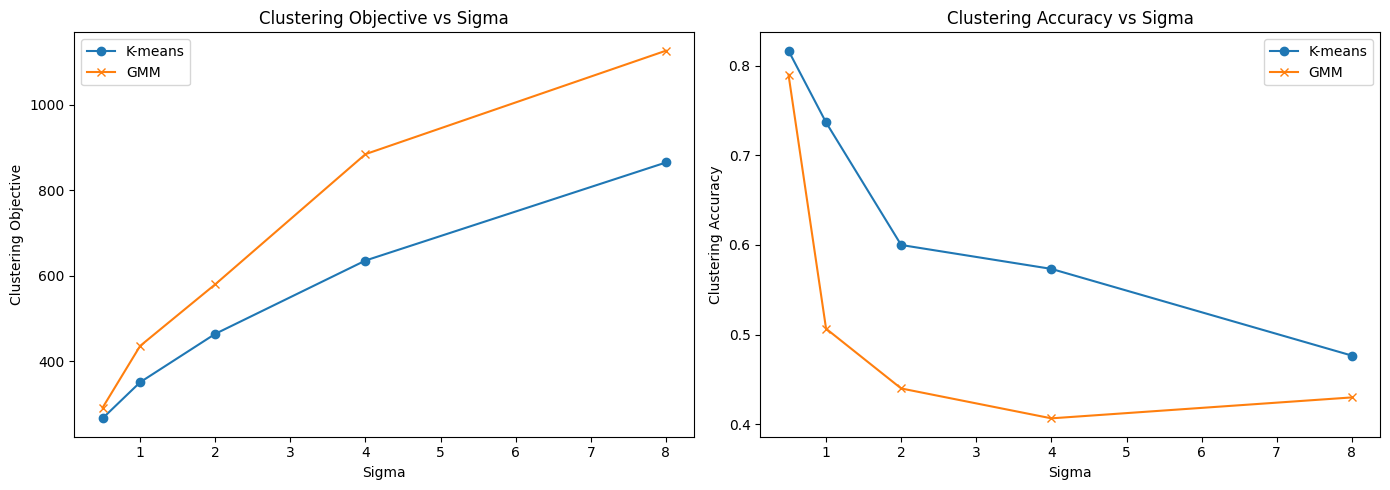

In [48]:
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment

# Helper function to compute the clustering objective
def clustering_objective(X, labels, centroids):
    return np.sum([np.linalg.norm(X[labels == i] - centroid, axis=1).sum() for i, centroid in enumerate(centroids)])

# Helper function to calculate accuracy
def calculate_accuracy(true_labels, pred_labels, n_clusters=3):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            cost_matrix[i, j] = np.sum((true_labels == i) & (pred_labels == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    return cost_matrix[row_ind, col_ind].sum() / true_labels.size


# Run the K-means and GMM algorithms along with accuracy calculations
kmeans_objectives = []
kmeans_accuracies = []
gmm_objectives = []
gmm_accuracies = []

# True labels for accuracy calculation
true_labels = np.concatenate((np.zeros(n_samples), np.ones(n_samples), np.full(n_samples, 2)))

# Execute both methods on the five datasets
for sigma in sigma_values:
    X = datasets[sigma]
    
    # K-means
    centroids, kmeans_labels = kmeans(X, k=3)
    kmeans_objectives.append(clustering_objective(X, kmeans_labels, centroids))
    kmeans_accuracies.append(calculate_accuracy(true_labels, kmeans_labels))
    
    # GMM
    means, _, _, responsibilities = gmm_em(X, k=3)
    gmm_labels = np.argmax(responsibilities, axis=1)
    gmm_objectives.append(clustering_objective(X, gmm_labels, means))
    gmm_accuracies.append(calculate_accuracy(true_labels, gmm_labels))

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for the clustering objective
axes[0].plot(sigma_values, kmeans_objectives, marker='o', label='K-means')
axes[0].plot(sigma_values, gmm_objectives, marker='x', label='GMM')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('Clustering Objective')
axes[0].set_title('Clustering Objective vs Sigma')
axes[0].legend()

# Plot for the clustering accuracy
axes[1].plot(sigma_values, kmeans_accuracies, marker='o', label='K-means')
axes[1].plot(sigma_values, gmm_accuracies, marker='x', label='GMM')
axes[1].set_xlabel('Sigma')
axes[1].set_ylabel('Clustering Accuracy')
axes[1].set_title('Clustering Accuracy vs Sigma')
axes[1].legend()

plt.tight_layout()
plt.show()
